In [1]:
# Import important packages/libraries
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import csv
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten
%matplotlib inline

seed = 42

In [2]:
# load files
with open( 'signnames.csv', 'r' ) as f:
    reader = csv.reader(f)
    sign_names = list(reader)
sign_names = sign_names[1::] #Remove csv header
NUM_CLASSES = len(sign_names)
print('Total number of classes: {}'.format(NUM_CLASSES) )

# load pickle files
train = pickle.load( open( "dataset/train.p", mode='rb' ) ) #important to set mode
X_train, y_train = train['features'], train['labels']


_, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH = X_train.shape

Total number of classes: 43


['2', 'Speed limit (50km/h)']


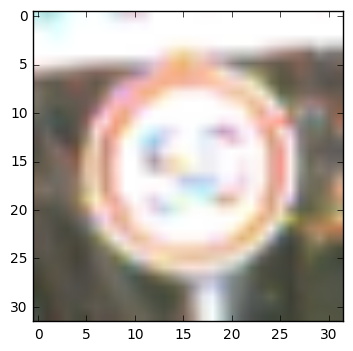

In [3]:
# Visualize image example

img_idx = random.randint(0, y_train.shape[0])
img = X_train[img_idx]
label = sign_names[y_train[img_idx]]
print(label)
plt.imshow(img)
plt.show()


In [4]:
print(10%2)

0


In [5]:
# Local Normalization LeCun
#centered to 0
#This demo illustrates the effect of a local normalization algorithm that uniformizes 
#the local mean and variance of an image. This is especially useful for correct non-uniform illumination
# or shading artifacts.  
#http://bigwww.epfl.ch/demo/jlocalnormalization/
# Normalization Layer
# Many types of normalization layers have been proposed for use in ConvNet architectures, sometimes 
#with the intentions of implementing inhibition schemes observed in the biological brain. 
#However, these layers have recently fallen out of favor because in practice their contribution 
#has been shown to be minimal, if any. For various types of normalizations, see the discussion in 
#Alex Krizhevsky's cuda-convnet library API.
   
def gaussian_filter(k_sz, k_depth, sigma=1.0):
    assert ksz % 2 == 0, "size of kernel needs to be odd number"  
    #initialize filter
    gauss_kernel = np.zeros((k_sz, k_sz), dtype=float32)
    center = np.ceil(k_sz / 2.)
    #fill-in gauss_kernel
    for depth in range(k_depth):
        for row in range(k_sz):
            for col in range(k_sz):
                exp_term = np.exp(-((center - col)**2 + (center - row)**2) )/(2.0 * sigma **2)
                gauss_kernel[row, col, depth] = 1/(2* np.pi * sigma**2) * exp_term
    
    #Normalize gaussian filter
    return gauss_kernel/(np.sum(gauss_kernel))

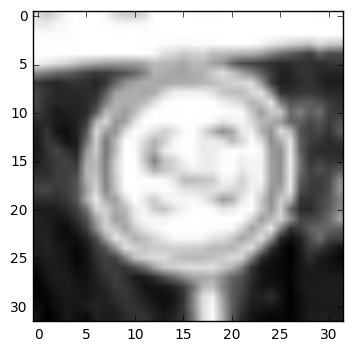

In [6]:
# data transformation
from skimage.color import rgb2gray
import skimage

#convert image to grayscale with skimage
img_gray = rgb2gray(img)
plt.imshow(img_gray, cmap='gray')
plt.show()

#convert to YUV so brightness cna be easily modified compared to RGB
#img_ycbcr = rgb2ycbcr(img)
#plt.imshow(img_ycbcr)
#plt.show()


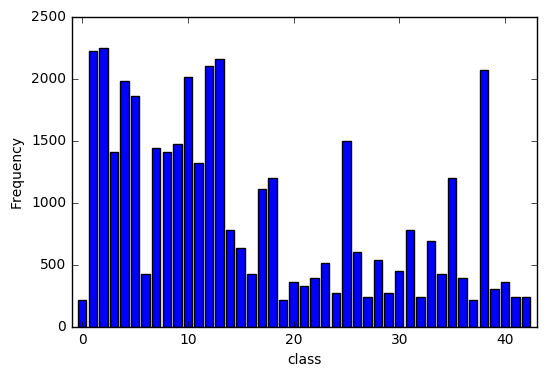

In [7]:
#data exploration : class distribution
#initialize counter

def get_count_imgs_per_class(y, verbose=False):
    num_classes = len(np.unique(y))
    count_imgs_per_class = np.zeros( num_classes )

    for this_class in range( num_classes ):
        if verbose: 
            print('class {} | count {}'.format(this_class, np.sum( y  == this_class )) )
        count_imgs_per_class[this_class] = np.sum(y == this_class )
    #sanity check
    assert np.sum(count_imgs_per_class) == len(y), "Discrepancy sum of examples of each class != total number of examples"
    return count_imgs_per_class

NUM_CLASSES = len( np.unique(y_train) )
plt.bar(np.arange(NUM_CLASSES), get_count_imgs_per_class(y_train), align='center')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.show()

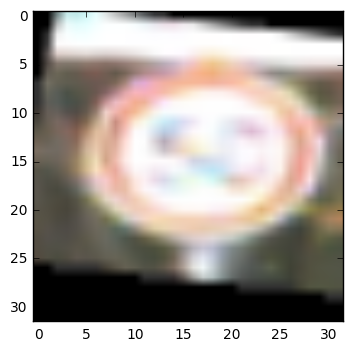

In [8]:
# image tansformation
from skimage import transform as transf

# modification: include brightness/contrast and background completion (instead of black)

def random_transform(img, angle_range=[-15, 15], zoom_range=[0.8, 1.2], shear_range=[10, -10], translation_range=[-5, 5]):
    """
    This function takes an image and performs a series of ramdom transformation on the fly.
    img - original image
    ang_range - angular range of the rotation [-15,+15] deg for example
    zoom_range - [0.8, 1.2]
    shear_range - [10,-10]
    translation_range : [-2, 2]
    """
    img_height, img_width, img_depth = img.shape
    
    # Generate random parameter values
    angle_value = np.random.uniform(low=angle_range[0], high=angle_range[1], size=None)
    zoomX = np.random.uniform(low=zoom_range[0], high=zoom_range[1], size=None)
    zoomY = np.random.uniform(low=zoom_range[0], high=zoom_range[1], size=None)
    shear_angle = np.random.uniform(low=shear_range[0], high=shear_range[1], size=None)
    translationX = np.random.randint(low=translation_range[0], high=translation_range[1]+1, size=None)
    translationY = np.random.randint(low=translation_range[0], high=translation_range[1]+1, size=None)

    #center images to run rotation about the image center rather than [0,0] point
    center_shift = np.array( [img_height, img_width] ) / 2. -0.5
    #transformation translation of the image: image center matches [0,0] orign
    transform_center = transf.SimilarityTransform( translation = -center_shift )
    transform_uncenter = transf.SimilarityTransform( translation = center_shift )

    # Image transformation : includes rotation, shear, tranlation, zoom
    transform_aug = transf.AffineTransform( rotation = np.deg2rad( angle_value ),
                                         scale = (1/zoomY, 1/zoomX),
                                         shear = np.deg2rad(shear_angle),
                                         translation = (translationY, translationX))

    # Make transformation
    full_transform = transform_center + transform_aug + transform_uncenter

    new_img = transf.warp( img, full_transform )

    return new_img

#def img_add_channel(batch):
    #convert image to grayscale and add 
    
new_img = random_transform(img)

plt.imshow(new_img)

Class 0 | Number of synthetic imgs 2290.0
Class 1 | Number of synthetic imgs 280.0
Class 2 | Number of synthetic imgs 250.0
Class 3 | Number of synthetic imgs 1090.0
Class 4 | Number of synthetic imgs 520.0
Class 5 | Number of synthetic imgs 640.0
Class 6 | Number of synthetic imgs 2080.0
Class 7 | Number of synthetic imgs 1060.0
Class 8 | Number of synthetic imgs 1090.0
Class 9 | Number of synthetic imgs 1030.0
Class 10 | Number of synthetic imgs 490.0
Class 11 | Number of synthetic imgs 1180.0
Class 12 | Number of synthetic imgs 400.0
Class 13 | Number of synthetic imgs 340.0
Class 14 | Number of synthetic imgs 1720.0
Class 15 | Number of synthetic imgs 1870.0
Class 16 | Number of synthetic imgs 2080.0
Class 17 | Number of synthetic imgs 1390.0
Class 18 | Number of synthetic imgs 1300.0
Class 19 | Number of synthetic imgs 2290.0
Class 20 | Number of synthetic imgs 2140.0
Class 21 | Number of synthetic imgs 2170.0
Class 22 | Number of synthetic imgs 2110.0
Class 23 | Number of synthet

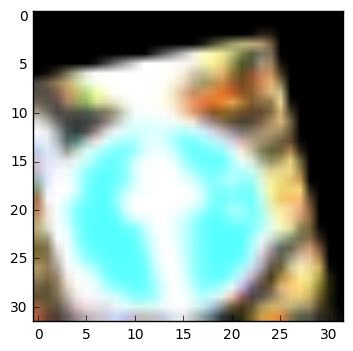

In [9]:
# Balance dataset
# set number of images per class: same or about that of the frequency of the majority class
max_imgs_per_class = 2500
NUM_CLASSES = len( np.unique(y_train) )

#list number of synthetic images to generate for each class
extra_imgs_per_class = max_imgs_per_class - get_count_imgs_per_class(y_train)
total_extra_imgs = np.sum( extra_imgs_per_class )

#if some classes are imbalanced -- run the data_balance_op
if total_extra_imgs != 0:
    # initialize tensor to store extra imgs
    X_extra = np.zeros( ( int(total_extra_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH ) )
    y_extra = np.zeros( int(total_extra_imgs) )
    # index where to start saving imgs and labels in extra_x, extra_y tensors
    start_idx = 0
    
    for this_class in range( NUM_CLASSES ):
        print('Class {} | Number of synthetic imgs {}'.format(this_class, extra_imgs_per_class[this_class]))
        num_extra_imgs = extra_imgs_per_class[ this_class ] #number of extra images to generate
        end_idx = start_idx + num_extra_imgs
        
        if num_extra_imgs > 0:
            #get ids of all images belonging to this_class
            all_imgs_id = np.argwhere( y_train == this_class )
            new_imgs_x = np.zeros( ( int(num_extra_imgs), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH ) )
            
            for k in range( int(num_extra_imgs) ):
                #randomly pick an image from original images belonging to this_class:
                rand_id = np.random.choice( all_imgs_id[0], size=None, replace=True )
                rand_img = X_train[rand_id]
                #Transform image
                new_img = random_transform( rand_img )
                new_imgs_x[k, :, :, :] = new_img
            X_extra[int(start_idx) : int(end_idx)] = new_imgs_x
            y_extra[int(start_idx) : int(end_idx)] = np.ones( ( int(num_extra_imgs), ) ) * this_class
        start_idx = end_idx
        
# Visualize a random image from X_extra synthetic dataset
rand_idx = np.random.randint( len( y_extra ) )
img = X_extra[rand_idx]
plt.imshow(img)
plt.show()

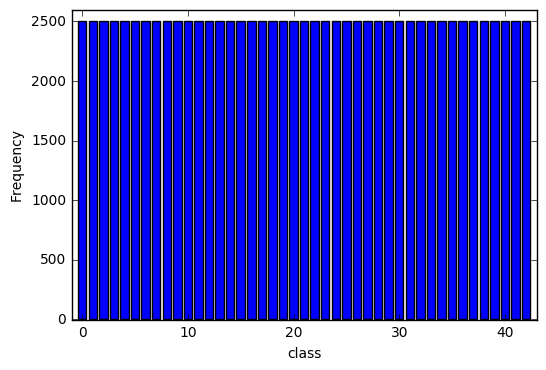

Total Number of images: 107500


In [10]:
#combine original dataset and extra dataset in a single tensor
X_train = np.concatenate( ( X_train, X_extra ), axis=0 )
y_train = np.concatenate( (y_train, y_extra), axis=0 )

# Check data Class distribution of merged dataset
NUM_CLASSES = len( np.unique( y_train ) )
plt.bar( np.arange( NUM_CLASSES ), get_count_imgs_per_class( y_train ), align='center' )
plt.xlabel('class')
plt.ylabel('Frequency')
plt.xlim([-1, 43])
plt.ylim([-1, 2600])
plt.show()

print( 'Total Number of images: {}'.format( X_train.shape[0] ) )

#free some space
del X_extra, y_extra

In [11]:
#shuffle data 

X_train, y_train = shuffle(X_train, y_train)

from sklearn.model_selection import train_test_split
# The dataset is split into train set and validation set with ratio 3:1
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.30, random_state=seed)
print('Train set size: {} | Validation set size: {}'.format(X_train.shape[0], X_validation.shape[0]))
EPOCHS = 10
BATCH_SIZE = 128

Train set size: 75250 | Validation set size: 32250


In [12]:
from tensorflow.contrib.layers import flatten
epsilon = 1e-6

def weight_variable(shape, mean, stddev, name):
    init = tf.truncated_normal(shape, mean=mean, stddev=stddev, seed = seed)
    return tf.Variable(init, name=name)
    
def bias_variable(shape, init_value, name):
    init = tf.constant(init_value, shape=shape)
    return tf.Variable(init, name=name)

def conv2d(x, W, strides, padding, name):
    return tf.nn.conv2d(x, W, strides=strides, padding=padding, name=name)

def max_2x2_pool(x, name):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID', name=name)

def normalization(dataset):
        for idx in range(dataset.shape[0]):
            img_r = (img[idx, :,:,0] - np.mean(img[idx, :,:,0])) / np.std(img[idx, :,:,0])
            img_g = (img[idx, :,:,1] - np.mean(img[idx, :,:,1])) / np.std(img[idx, :,:,1])
            img_b = (img[idx, :,:,2] - np.mean(img[idx, :,:,2])) / np.std(img[idx, :,:,2])
            dataset[idx, :,:,0] = img_r
            dataset[idx, :,:,1] = img_g
            dataset[idx, :,:,2] = img_b
        return dataset
    
def LeNet(x, img_depth, n_classes):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    # Define Variables
    k_conv1 = [5, 6] # 6 kernels of size (5*5)
    W_conv1 = weight_variable([k_conv1[0], k_conv1[0], img_depth, k_conv1[1]], mean=mu, stddev=sigma, name='W_conv1')
    #b_conv1 = bias_variable(shape=[k_conv1[1]])
    b_conv1 = bias_variable(shape=[k_conv1[1]], init_value=0.0, name='b_conv1')
    #convolution operation
    conv1 = conv2d(x, W_conv1, strides=[1,1,1,1], padding='VALID', name='conv1_op')
    # Activation.
    conv1 = tf.nn.relu(conv1 + b_conv1, name='conv1_act')

    # Subsampling operation (max Pooling) ==> Input = 28x28x6. Output = 14x14x6.
    pool1 = max_2x2_pool(conv1, name='conv1_pool')

    # Layer 2: Convolutional. Output = 10x10x16.
    #Define Variables
    k_conv2 = [5, 16] # 16 kernels of size (5*5)
    W_conv2 = weight_variable([k_conv2[0], k_conv2[0], k_conv1[1], k_conv2[1]], mean=mu, stddev=sigma, name='W_conv2')
    b_conv2 = bias_variable(shape=[k_conv2[1]], init_value=0.0, name='b_conv2')
    #convolution operation + bias
    conv2 = conv2d(pool1, W_conv2, strides=[1,1,1,1], padding='VALID', name='conv2_op')
    # Activation.
    conv2 = tf.nn.relu(conv2 + b_conv2, name='conv2_act' )

    # Subsampling operation (max Pooling) ==> Input = 10x10x16. Output = 5*5*16.
    pool2 = max_2x2_pool(conv2, name='conv2_pool')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(pool2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    W_fc1 = weight_variable([400, 120], mean=mu, stddev=sigma, name='W_fc1')
    b_fc1 = bias_variable([120], init_value=0.0, name='b_fc1')
    # TODO: Activation.
    fc1 = tf.nn.relu( tf.matmul( fc0, W_fc1 ) + b_fc1, name='fc1_act' )
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    W_fc2 = weight_variable([120, 84], mean=mu, stddev=sigma, name='fc_2')
    b_fc2 = bias_variable([84], init_value=0.0, name='b_fc2')
    # TODO: Activation.
    fc2 = tf.nn.relu( tf.matmul( fc1, W_fc2 ) + b_fc2, name='fc2_act' )
 
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    W_fc3 = weight_variable([84,n_classes], mean=mu, stddev=0.1, name='W_fc3')
    b_fc3 = bias_variable([n_classes], init_value=0.0, name='b_fc3')
    # TODO: Activation.
    logits = tf.add(tf.matmul(fc2, W_fc3),b_fc3, name='logits')  
    
    return logits

In [13]:
# start building graph with nodes of input and output classes
# Features and Labels

x = tf.placeholder(tf.float32, ( None, IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH ) )
y = tf.placeholder( tf.int32, ( None ) )

one_hot_y = tf.one_hot(y, NUM_CLASSES )


In [14]:
# Training Pipeline

rate = 0.001

#get logits from LeNet function (training operation)
logits = LeNet(x, IMG_DEPTH, NUM_CLASSES)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits( logits, one_hot_y )


#regularizer = regularizer_conv * ( tf.nn.l2_loss(W_conv1) + tf.nn.l2_loss(W_conv2) ) + \
#                regularizer_fc * ( tf.nn.l2_loss(W_fc1) + tf.nn.l2_loss(W_fc2) + tf.nn.l2_loss(W_fc3) )

loss = tf.reduce_mean( cross_entropy ) #+ regularizer

optimizer = tf.train.AdamOptimizer( learning_rate = rate )
training_operation = optimizer.minimize( loss )

In [15]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    try:
        saver
    except NameError:
        saver = tf.train.Saver()
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.632

EPOCH 2 ...
Validation Accuracy = 0.905

EPOCH 3 ...
Validation Accuracy = 0.945

EPOCH 4 ...
Validation Accuracy = 0.957

EPOCH 5 ...
Validation Accuracy = 0.949

EPOCH 6 ...
Validation Accuracy = 0.944

EPOCH 7 ...
Validation Accuracy = 0.967

EPOCH 8 ...
Validation Accuracy = 0.966

EPOCH 9 ...
Validation Accuracy = 0.976

EPOCH 10 ...
Validation Accuracy = 0.980

Model saved


In [17]:
test = pickle.load( open( "dataset/test.p", mode='rb' ) ) #important to set mode
X_test, y_test = test['features'], test['labels']
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('lenet.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.877


# Normalization gives worst performanceon color images
Other than subtracting the mean image, and dividing by the standard deviation image, I made no modifications to the images entering the network. Early runs used grayscale images to lessen runtime.
For input into the network, histogram normalization with graphicsmagick gave marginal improvements using grayscale images, and slightly worse performance when using color images. I never tried local contrast normalization simply because it has fallen out of favor.

sigma initialization of the weights is very important:
sigma = 0.5 too high (low validation accuracy)
sigma = 0.1
